# A/Bテストの有意差検定
二項分布が近似的に正規分布に近づく性質を利用し、A/Bテストの有意差検定と検定力の計算を行う。



In [2]:
import numpy as np
import scipy as sp
import scipy.stats

import matplotlib.pylab as plt
import seaborn as sns

# 有意差検定
まずは、クリック列を有意差検定する例を示す。

{X}, {Y}をそれぞれサイトX,Yがクリックされたかどうかを表す0,1列とし、それぞれのサイトのクリック率に差があるかどうかを検定する。

サイトX, Yのクリック率を$p_1, p_2$とし、

- 帰無仮説$H_0$: $p_1 = p_2$
- 対立仮説$H_1$: $p_1 \neq p_2$

とする。帰無仮説が棄却されるとき、対立仮説が成り立ちサイトX, Yのクリック率に有意差があることがわかる。

In [3]:
# 真のclick rate
p1, p2 = 0.08, 0.08
# サンプル数
n1, n2 = 4000, 5000
# 有意水準
alpha = 0.05

# 観測値
X = sp.stats.bernoulli.rvs(size=n1, p=p1)
Y = sp.stats.bernoulli.rvs(size=n2, p=p2)
p1_ = X.mean()
p2_ = Y.mean()

# 検定統計量
u = (p1_ - p2_) / np.sqrt(p1_*(1-p1_)/n1 + p2_*(1-p2_)/n2)
# 検定統計量が従う分布
lower, upper = sp.stats.norm.interval(alpha=1-alpha)

print (f"t:{u:.3f} lower:{lower:.3f} upper:{upper:.3f}")

if u < lower or u > upper:
    print("有意差あり")
else:
    print("有意差なし")

t:-0.253 lower:-1.960 upper:1.960
有意差なし


# 検定の検証
検定が正しいかどうかを検証するために、帰無仮説$H_0$が成り立つときの、

In [4]:
# 真のclick rate
p1, p2 = 0.08, 0.08
# サンプル数
n1, n2 = 300, 400
# 有意水準
alpha = 0.05

trial = 100000

list_u = []
for t in range(trial):
    # 観測値
    X = sp.stats.bernoulli.rvs(size=n1, p=p1)
    Y = sp.stats.bernoulli.rvs(size=n2, p=p2)
    p1_ = X.mean()
    p2_ = Y.mean()
    # 検定統計量
    u = (p1_ - p2_) / np.sqrt(p1_*(1-p1_)/n1 + p2_*(1-p2_)/n2)
    list_u.append(u)

# 検定統計量が従う分布
lower, upper = sp.stats.norm.interval(alpha=1-alpha)
us = np.array(list_u)

C:\Users\laket\Anaconda3\envs\halite\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


棄却率: 0.04975


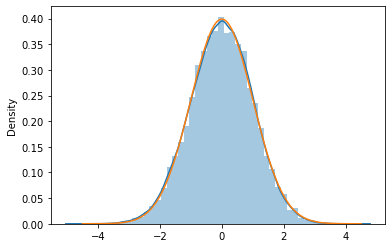

In [5]:
sns.distplot(us, label="sample")
# 検定統計量が従う分布
plot_us = np.linspace(-4.5, 4.5, 300)
density = sp.stats.norm.pdf(x=plot_us)

plt.plot(plot_us, density, label="distribution")
drop_rate = ((us > upper) | (us < lower)).mean()
print(f"棄却率: {drop_rate}")
#print (f"t:{t:.3f} lower:{lower:.3f} upper:{upper:.3f}")

# 検定力の導出

対立仮説$H_1$が成り立つ状況下で、正しく$H_0$が棄却される確率$1-\beta$を求める。

この確率は、$p1, p2$の値に依存する。
$p1$は既存のサイトの訪問率などで観測できることが多いが、
$p2$は改修後のサイトの訪問率などに相当するため、事前に観測できないことが多い。

決定するガイドライン存在する(サンプルサイズの決め方p33)が、今回は$p2$を期待する訪問率として与える。

In [6]:
# 真のclick rate
p1, p2 = 0.23, 0.18
n1, n2 = 600, 600
alpha = 0.05

mu = (p1 - p2) / np.sqrt(p1*(1-p1)/n1+p2*(1-p2)/n2)
model = sp.stats.norm(loc=mu)
lower, upper = sp.stats.norm.interval(alpha=1-alpha)
power = 1 - (model.cdf(upper) - model.cdf(lower))

print (f"検出力: {power}")

検出力: 0.5751195490802143


# 検出力の検証
実際に対立仮説が成り立つ状況の棄却される割合を計算する。

In [ ]:
trial = 1000000

list_u = []
for t in range(trial):
    # 観測値
    X = sp.stats.bernoulli.rvs(size=n1, p=p1)
    Y = sp.stats.bernoulli.rvs(size=n2, p=p2)
    p1_ = X.mean()
    p2_ = Y.mean()
    # 検定統計量
    u = (p1_ - p2_) / np.sqrt(p1_*(1-p1_)/n1 + p2_*(1-p2_)/n2)
    list_u.append(u)

# 検定統計量が従う分布
lower, upper = sp.stats.norm.interval(alpha=1-alpha)
us = np.array(list_u)

sns.distplot(us, label="sample")
# 検定統計量が従う分布
plot_us = np.linspace(-4.5, 4.5, 300)
density = sp.stats.norm.pdf(x=plot_us)

plt.plot(plot_us, density, label="distribution")
drop_rate = ((us > upper) | (us < lower)).mean()
print(f"棄却率: {drop_rate}")

# サンプルサイズの計算
検出力が基準(power=0.8)に達するサンプルサイズを求めて、必要サンプルサイズとする。
近似式が立てられるかもしれないが二分探索で求める。

In [ ]:
# 真のclick rate
p1, p2 = 0.12, 0.132

alpha = 0.1

def calc_power(n):
    mu = (p1 - p2) / np.sqrt(p1*(1-p1)/n+p2*(1-p2)/n)
    model = sp.stats.norm(loc=mu)
    lower, upper = sp.stats.norm.interval(alpha=1-alpha)
    power = 1 - (model.cdf(upper) - model.cdf(lower))
    return power

lower = 10
upper = 100000
target_power = 0.8
sample = None
prev_sample = None

while True:
    prev_sample = sample
    sample = int((lower+upper) / 2)

    if prev_sample == sample:
        break

    cur_power = calc_power(sample)

    print (f"sample: {sample} power: {cur_power}")

    if cur_power > target_power:
        upper = sample
    else:
        lower = sample


# Qiita用のコード

In [ ]:
def test(X, Y, alpha):
    p1_ = X.mean()
    p2_ = Y.mean()
    u = (p1_ - p2_) / np.sqrt(p1_*(1-p1_)/n1 + p2_*(1-p2_)/n2)
    # 検定統計量が従う分布
    lower, upper = sp.stats.norm.interval(alpha=1-alpha)

    if u < lower or u > upper:
        return True
    else:
        return False

# 真のclick rate
p1, p2 = 0.08, 0.10
# サンプル数
n1, n2 = 400, 400
res = []
for i in range(100000):
    X = sp.stats.bernoulli.rvs(size=n1, p=p1)
    Y = sp.stats.bernoulli.rvs(size=n2, p=p2)
    res.append(test(X, Y, alpha=0.05))

print(f"棄却率: {np.mean(res)}")

In [ ]:
p1, p2 = 0.08, 0.10
n1, n2 = 400, 400
alpha = 0.05

def power(p1, p2, n1, n2, alpha):
    u = (p1 - p2) / np.sqrt(p1*(1-p1)/n1+p2*(1-p2)/n2)
    model = sp.stats.norm(loc=u)
    lower, upper = sp.stats.norm.interval(alpha=1-alpha)
    power = 1 - (model.cdf(upper) - model.cdf(lower))

    #print (f"検出力: {power:.5f}")
    return power

power(p1, p2, n1, n2, alpha)

In [ ]:
lower_n, upper_n = 10, 100000
alpha = 0.05
target_power = 0.8
p1 = 0.08
p2 = 0.10

while True:
    n = int((lower_n + upper_n) / 2)
    p = power(p1, p2, n, n, alpha)
    if p > target_power:
        upper_n = n
    else:
        lower_n = n
    if (upper_n - lower_n) <= 1:
        break

print (f"必要サンプルサイズ: {upper_n}")